In [224]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

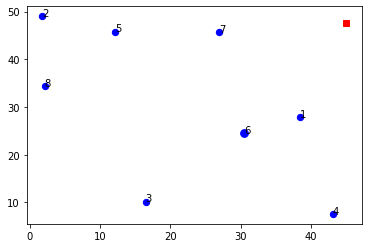

In [225]:
# N: The number of customers
# M: The number of employees
# V: The set of nodes (customers)
# location: the coordinate of each node
# d: the maintenance time (demand) of the customers
# c: the travel time betwwen two location i and j
# capacity: the maximum maintenance time of an employee

N = 8
M = 2
V = set(range(N+1))
location = [(np.random.uniform(0,50), np.random.uniform(0,50))]
plt.plot(location[-1][0], location[-1][1],'rs')

d = [0]
for i in V - {0}:
    location.append((np.random.uniform(0,50),np.random.uniform(0,50)))
    d.append(random.randint(1,3))
    plt.scatter(location[-1][0],location[-1][1],d[-1]*20,'b')
    plt.text(location[-1][0],location[-1][1],str(i))

plt.show()

def distance(a,b):
    return math.sqrt((a[0]-b[0])*(a[0]-b[0]) + (a[1]-b[1])*(a[1]-b[1]))

c = [[0 if i == j 
      else distance(location[i], location[j]) 
      for j in V] for i in V]
sum_c = 0
for rows in c:
    sum_c += sum(rows)
capacity = math.ceil((sum(d))/M)

# M = math.ceil(sum(d)/capacity)
# print(M)

In [226]:
def TSP_tour_cost(y,c,N):
    y.append(y[0])
    cost = 0
    for i in range(N):
        cost += c[y[i]][y[i+1]]
    y.pop(-1)
    return cost


def TSP_tour_plot(y,location,N):
    y.append(y[0])
    for i in range(N):
        plt.plot([location[y[i]][0], location[y[i+1]][0]],[location[y[i]][1], location[y[i+1]][1]],'r')
#     plt.show()
    y.pop(-1)

# print(TSP_tour_cost(y,c,N))
# TSP_tour_plot(y,location,N)

def TSP_onestep_opt2(y,c,N):
    y.append(y[0])
    for i in range(N-2):
        for j in range(i+2,N):
            total_distance_pre = c[y[i]][y[i+1]] + c[y[j]][y[j+1]]
            total_distance_post = c[y[i]][y[j]] + c[y[i+1]][y[j+1]]
            # print(y[i],y[i+1],y[j],y[j+1],total_distance_pre-total_distance_post)
            if total_distance_post < total_distance_pre:
                for k in range(math.ceil(((j-1-i)/2))):
                    temp = y[i+1+k]
                    y[i+1+k] = y[j-k]
                    y[j-k] = temp
                y.pop(-1)
                return (1,y)
    y.pop(-1)
    return (0,y)

def TSP_opt2(y,c,N,max_iter):
    cost_record = []
    for i in range(max_iter):
        (label,y) = TSP_onestep_opt2(y,c,N)
        cost_record.append(TSP_tour_cost(y,c,N))
        if label == 0:
            break
    return (cost_record, y)

In [227]:
customer_permutation = np.random.permutation(N) + 1
print(customer_permutation)
seed_customer = set(customer_permutation[0:M])
print(seed_customer)
other_customer = V - {0} - seed_customer
print(other_customer)


[1 7 6 4 5 3 8 2]
{1, 7}
{2, 3, 4, 5, 6, 8}


In [228]:
allocating_cost = {}
for i in other_customer:
    for m in seed_customer:
        allocating_cost[i,m] = min(c[0][i] + c[i][m] + c[m][0], c[0][m] + c[m][i])- (c[0][m] + c[m][0])
        allocating_cost[i,m] = round(allocating_cost[i,m]*1000)

print(allocating_cost)

{(2, 1): 21490, (2, 7): 7137, (3, 1): 7402, (3, 7): 18785, (4, 1): 34, (4, 7): 23156, (5, 1): 10945, (5, 7): -3499, (6, 1): -12183, (6, 7): 3259, (8, 1): 16040, (8, 7): 9001}


In [229]:
import networkx as nx
G = nx.DiGraph()

for m in seed_customer:
    G.add_node(m,demand = -(capacity - d[m]))
for i in other_customer:
    G.add_node(i, demand = d[i])

for i in other_customer:
    for m in seed_customer:
        G.add_edge(m,i,weight = allocating_cost[i,m])
G.add_node(0,demand = capacity*M - sum(d))
for m in seed_customer:
    G.add_edge(m,0,weight = 0)

flowCost,flowDict = nx.network_simplex(G)

for m in seed_customer:
    for i in other_customer:
        if flowDict[m][i] > 0.1:
            print(m,i,flowDict[m][i])


1 3 2
1 4 2
1 6 3
7 2 2
7 5 2
7 8 2


In [230]:
group = []
for m in seed_customer:
    subgroup = [0,m]
    for i in other_customer:
        if flowDict[m][i] > 0.1:
            subgroup.append(i)
    group.append(subgroup)
print(group)

[[0, 1, 2, 3, 4, 5, 6, 8], [0, 7, 2, 3, 4, 5, 6, 8]]


In [231]:
c_group = []
location_group = []
for subgroup in group:
    c_group.append([[c[i][j] for j in subgroup] for i in subgroup])
    location_group.append([location[i] for i in subgroup])

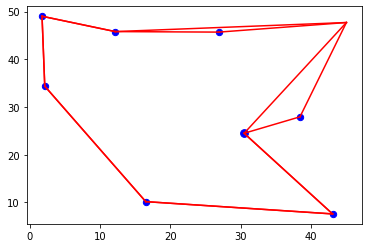

325.93981419081217


In [232]:
max_iter = 100000
total_cost = 0
for m in range(M):
    sub_node = group[m]
    sub_N = len(sub_node)
    sub_c = c_group[m]
    sub_y = list(range(sub_N))
    sub_location = location_group[m]
    cost_record, sub_y = TSP_opt2(sub_y, sub_c,sub_N, max_iter)
    TSP_tour_plot(sub_y,sub_location,sub_N)
    total_cost += cost_record[-1]

for i in V-{0}:
    plt.scatter(location[i][0],location[i][1],d[i]*20,'b')
plt.show()
print(total_cost)